# Quantum adder 

### Based on QUANTUM ARITHMETIC OPERATIONS BASED ON QUANTUM FOURIER TRANSFORM ON SIGNED INTEGERS
https://arxiv.org/pdf/2005.00443.pdf

In [370]:
from qiskit import Aer, transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import ControlledGate
import numpy as np

### Define two integers to add and encode them into quantum information

In [472]:
a = 4
b = 4

bin_a = bin(a)[2:].zfill(4)
bin_b = bin(b)[2:].zfill(4)
print(bin_a)
print(bin_b)

num_qubits = len(bin_a) + len(bin_b) + 1

0100
0100


### Define the encoding circuit and QFT circuit

In [473]:
def encode(bin_a, bin_b):
    encoding_circuit = QuantumCircuit(num_qubits - 1, name="Encode")
    for i, b in enumerate(bin_a):
        if int(b) == 1:
            encoding_circuit.x(i)
    for i, b in enumerate(bin_b):
        if int(b) == 1:
            encoding_circuit.x(len(bin_a) + i)
    return encoding_circuit

def build_qft(len_a):
    qft = QuantumCircuit(len_a + 1, name="QFT")
    for i in range(len_a + 1):
        qft.h(i)
        for k, j in enumerate(range(i + 1, len_a + 1), start=2):
            qft.cp(theta = 2 * np.pi / 2 ** (k), control_qubit=i, target_qubit=j)
    return qft

encoding_circuit = encode(bin_a, bin_b)
qft = build_qft(len(bin_a))

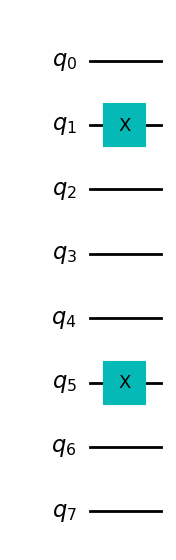

In [474]:
encoding_circuit.draw('mpl')

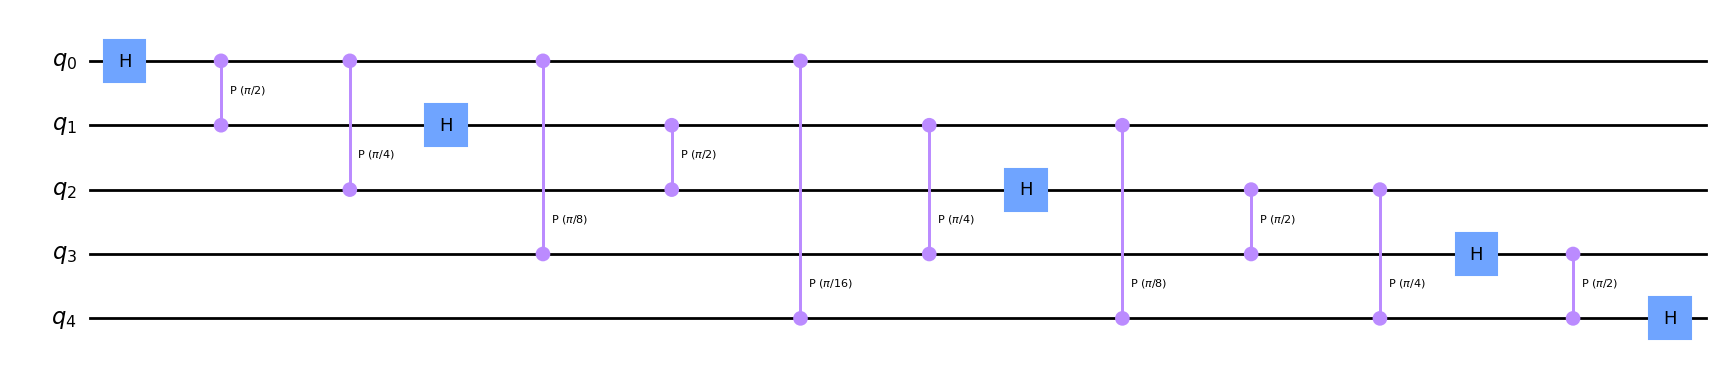

In [475]:
qft.draw('mpl')

### Define non-modular addition (nMAdd) circuit

In [476]:
def non_modular_addition(len_a, len_b):
    circ = QuantumCircuit(num_qubits, name="nMAdd") # Init circuit
    circ.cp(theta = 2 * np.pi / 2, control_qubit=num_qubits - 1, target_qubit=len_a)
    for i in reversed(range(1, len_a)): # Start from last qubit of |a> to first qubit
        for k, j in enumerate(range(i + len_b, num_qubits), start=1): # Start from i + len(b) to last qubit
            control_qubit = j
            target_qubit = i
            circ.cp(theta = 2 * np.pi / 2 ** k, control_qubit=control_qubit, target_qubit=target_qubit, label=f"R{k+1}")
    for k, i in enumerate(range(1 + len_a, num_qubits), start=2):
        circ.cp(theta=2 * np.pi / 2 ** k, control_qubit=i, target_qubit=0)
    return circ

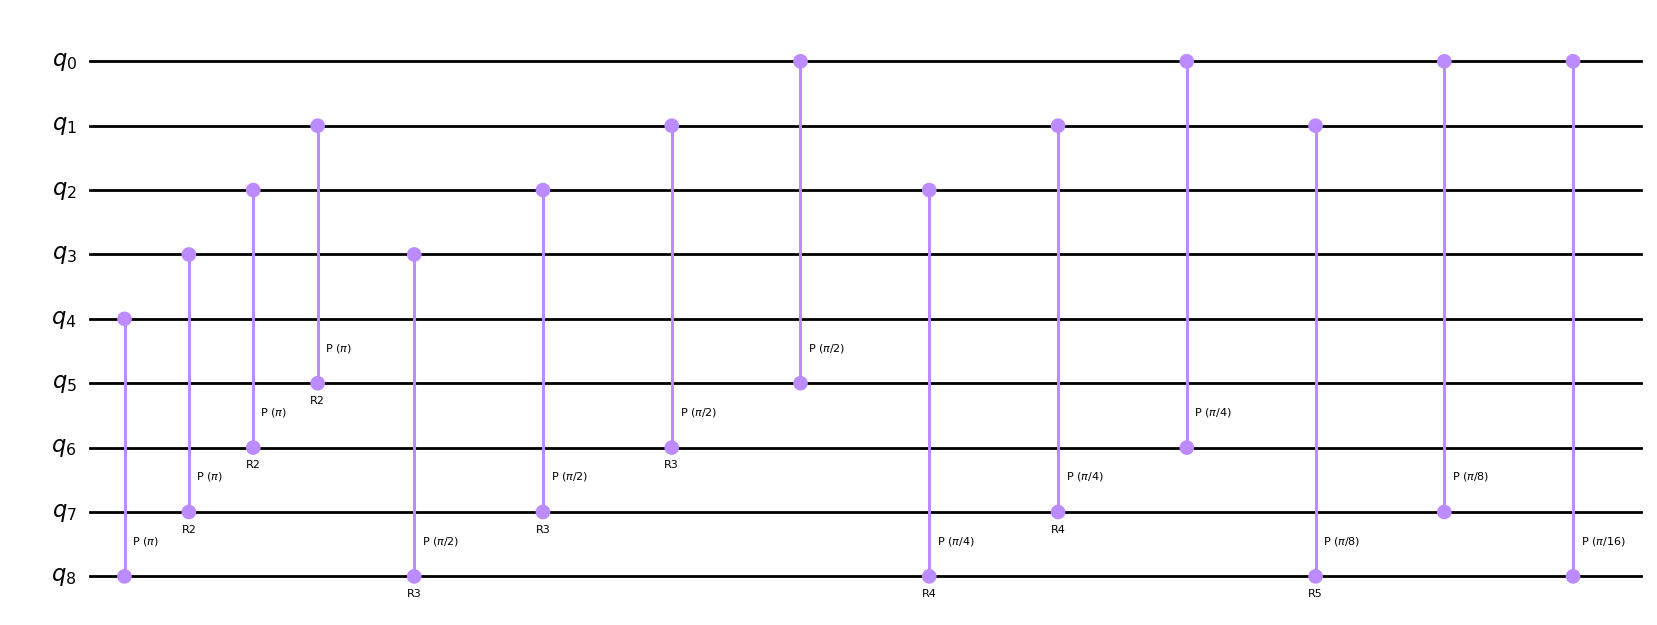

In [477]:
non_modular_addition_circ = non_modular_addition(len(bin_a), len(bin_b))
non_modular_addition_circ.draw('mpl')

### Build the whole quantum circuit

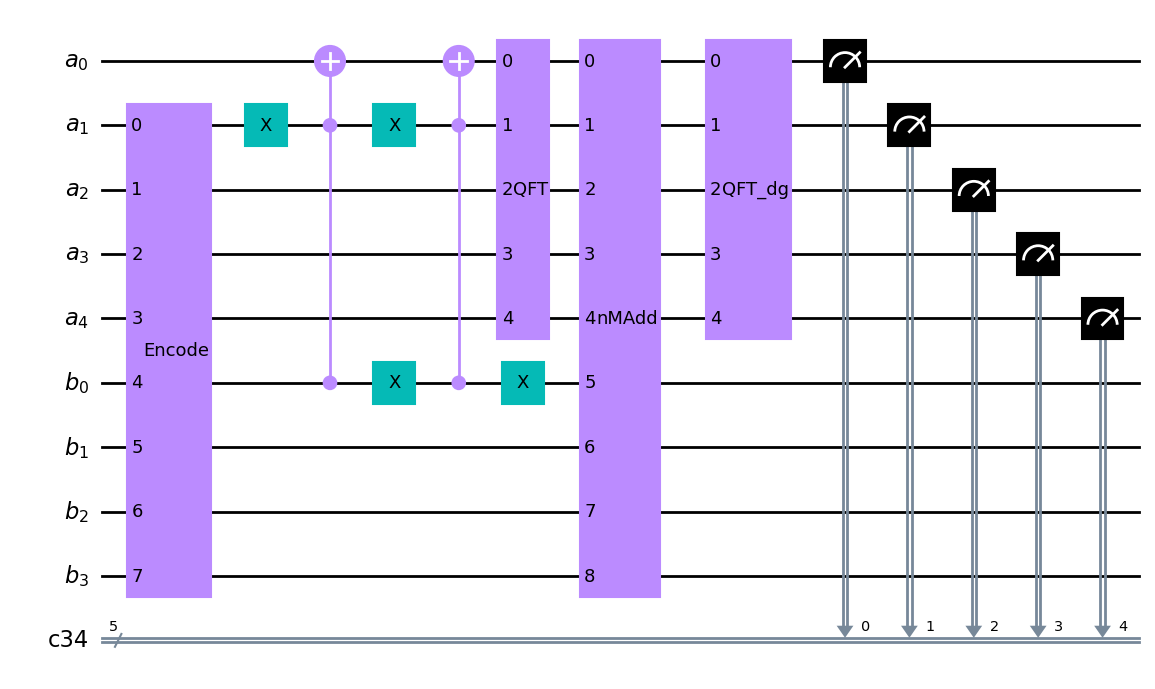

In [478]:
# Create a quantum circuit with the number of bits we need to represent our binary integers to add
circ = QuantumCircuit(QuantumRegister(len(bin_a) + 1, name="a"), QuantumRegister(len(bin_b), name="b"), ClassicalRegister(len(bin_a) + 1))

# Encode the integer into binary
circ.append(encoding_circuit, [i for i in range(1, num_qubits)])

# Apply Toffoli gates
# First Toffoli gate is 0-controlled on |a1>
# Second Toffoli gate is 0-controlled on |b1>
circ.x(1) # Add X gate to ensure 0-control
circ.toffoli(1 + len(bin_a), 1, 0)
circ.x(1) # Remove X gate
circ.x(1 + len(bin_a)) # Add X gate to ensure 0-control
circ.toffoli(1, 1 + len(bin_a), 0)
circ.x(1 + len(bin_a)) # Remove X gate

# Apply QFT on qubit of first integer
circ.append(qft, [i for i in range(len(bin_a) + 1)])

circ.append(non_modular_addition_circ, [i for i in range(num_qubits)])
circ.append(qft.inverse(), [i for i in range(len(bin_a) + 1)])

circ.measure([i for i in range(len(bin_a) + 1)], [i for i in range(len(bin_a) + 1)])
circ.draw('mpl')

In [479]:
backend = Aer.get_backend('aer_simulator_statevector')
circ = transpile(circ, backend)

In [480]:
result = backend.run(circ).result().get_counts(circ)
print(a, "+", b)
print(result)
binstr = list(result.keys())[0]
binstr = binstr[::-1]
res = int(binstr, 2)
print(res)


4 + 4
{'00010': 1024}
8


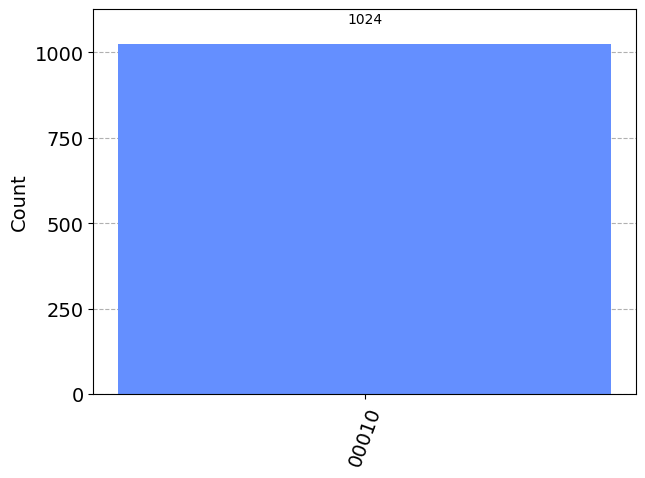

In [481]:
plot_histogram(result)